In [1]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [2]:
gen = ImageDataGenerator(rescale=1./255,validation_split = 0.2,zoom_range=(0.99,0.99),dtype=tf.float32)

In [3]:
train = gen.flow_from_directory("../../BrainTumor/Data/DataSet/",
                               target_size = (150,150),
                               batch_size = 256,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "training")
                
val = gen.flow_from_directory("../../BrainTumor/Data/DataSet/",
                               target_size = (150,150),
                               batch_size = 8,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "validation")
classes = val.class_indices

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


In [4]:
classes

{'BrainTumor': 0, 'Healthy': 1}

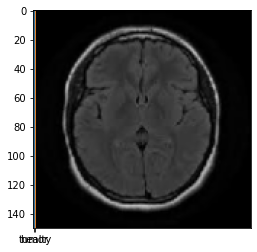

In [5]:
t=0
h=0
for i in range(15):
    a, b = next(train)
    for j in b:
        if j == 1:
            h+=1
        else:t+=1

sns.barplot(x=['tumor','healty'],y=[t,h])
import matplotlib.pyplot as plt
batch = next(train)

plt.imshow(batch[0][0])

In [6]:
from keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout, Dense, InputLayer, Flatten, Input
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from tensorflow.keras import layers

In [7]:
input_tensor = Input(shape=(100, 100, 3))  # this assumes K.image_data_format() == 'channels_last'

resnet_model = ResNet50(input_tensor=input_tensor,weights='imagenet', include_top=False)

for layer in resnet_model.layers:
    layer.trainable=False

resnet = Sequential()
resnet.add(resnet_model)
resnet.add(layers.Conv2D(32, kernel_size=(3,3), strides=(3,3), activation='relu', padding='same', input_shape=(100, 100, 1)))
resnet.add(layers.ReLU())
resnet.add(layers.MaxPooling2D(pool_size=(2,2)))
resnet.add(layers.Flatten())
resnet.add(layers.Dense(activation='relu', units=64))
resnet.add(layers.Dropout(0.2))
resnet.add(layers.Dense(activation='sigmoid', units=1))

resnet.compile(optimizer=Adam(0.001),loss = MeanSquaredError(),metrics=['accuracy'])

resnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 32)          589856    
_________________________________________________________________
re_lu (ReLU)                 (None, 2, 2, 32)          0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [8]:
from keras import utils, callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

In [9]:
history = resnet.fit(train,verbose=1,callbacks = [earlystopping],epochs=20,validation_data=(val))

Epoch 1/20
15/15 [==============================] - 132s 9s/step - loss: 0.2427 - accuracy: 0.5778 - val_loss: 0.2156 - val_accuracy: 0.6453
Epoch 2/20
15/15 [==============================] - 128s 9s/step - loss: 0.2000 - accuracy: 0.7055 - val_loss: 0.2051 - val_accuracy: 0.6812
Epoch 3/20
15/15 [==============================] - 144s 10s/step - loss: 0.1851 - accuracy: 0.7324 - val_loss: 0.2039 - val_accuracy: 0.6801
Epoch 4/20
15/15 [==============================] - 143s 10s/step - loss: 0.1857 - accuracy: 0.7259 - val_loss: 0.1884 - val_accuracy: 0.7225
Epoch 5/20
15/15 [==============================] - 132s 9s/step - loss: 0.1813 - accuracy: 0.7311 - val_loss: 0.1835 - val_accuracy: 0.7203
Epoch 6/20
15/15 [==============================] - 127s 8s/step - loss: 0.1678 - accuracy: 0.7609 - val_loss: 0.1740 - val_accuracy: 0.7661
Epoch 7/20
15/15 [==============================] - 128s 9s/step - loss: 0.1571 - accuracy: 0.7829 - val_loss: 0.1712 - val_accuracy: 0.7421
Epoch 8/20


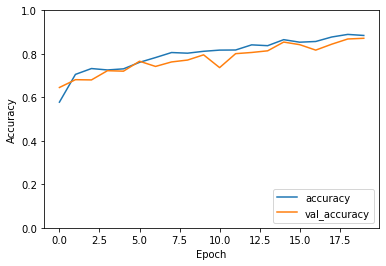

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


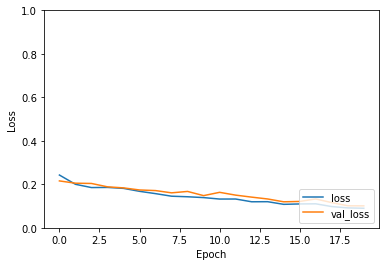

In [11]:

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [12]:
gen = ImageDataGenerator(rescale=1./255,zoom_range=(0.99,0.99),dtype=tf.float32)
test = gen.flow_from_directory("../../Test/DataSet/",
                               target_size = (150,150),
                               batch_size = 256,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = 123,
                               subset = "training")

classes = val.class_indices

Found 245 images belonging to 2 classes.


In [13]:
_, acc  = resnet.evaluate(test, verbose=1)

1/1 [==============================] - 0s 998us/step - loss: 0.0851 - accuracy: 0.9020
